In [1]:
from typing import Dict, Iterable, List, Optional, Tuple, Union
import qiskit
from qiskit.visualization import plot_gate_map

from pytket.qiskit import qiskit_to_tk
from pytket.utils import Graph
from pytket import Circuit, OpType
from pytket.qiskit import process_characterisation
from pytket.backends.resulthandle import _ResultIdTuple
from pytket.backends import Backend
from pytket.device import Device
from pytket.routing import NoiseAwarePlacement, Architecture
from pytket.passes import (
    BasePass,
    RebaseIBM,
    SequencePass,
    SynthesiseIBM,
    CXMappingPass,
    DecomposeBoxes,
    FullPeepholeOptimise,
    CliffordSimp,
)
from pytket.predicates import (
    NoMidMeasurePredicate,
    NoSymbolsPredicate,
    DirectednessPredicate,
    GateSetPredicate,
    NoClassicalControlPredicate,
    NoFastFeedforwardPredicate,
    Predicate,
)



from mock.MockBackends_Qiskit import FakeOwnBackend

[[Nduv('2020-12-12T06:29:08+09:00', T1, us, 184.73939094432617), Nduv('2020-12-12T06:30:26+09:00', T2, us, 195.43514807207902), Nduv('2020-12-12T06:42:53+09:00', frequency, GHz, 4.974446855948306), Nduv('2020-12-12T06:42:53+09:00', anharmonicity, GHz, -0.34847270441069783), Nduv('2020-12-12T06:27:24+09:00', readout_error, , 0.061900000000000066), Nduv('2020-12-12T06:27:24+09:00', prob_meas0_prep1, , 0.0754), Nduv('2020-12-12T06:27:24+09:00', prob_meas1_prep0, , 0.0484), Nduv('2020-12-12T06:27:24+09:00', readout_length, ns, 3555.555555555555)]]
        ┌───┐ ░ ┌─┐
   q_0: ┤ H ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0 
        ┌──────────┐ ░ ┌─┐
   q_0: ┤ U2(0,pi) ├─░─┤M├
        └──────────┘ ░ └╥┘
meas: 1/════════════════╩═
                        0 


# 1. Create a custom Qiskit backend

create a custom fake backend for testing

In [2]:
my_qiskit_fake_backend = FakeOwnBackend()

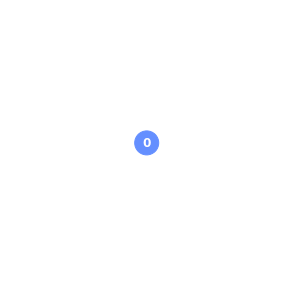

In [3]:
plot_gate_map(my_qiskit_fake_backend)

# 2. Convert to Tket

In [4]:
class FakeTKetIBMBackend(Backend):
    
    def __init__(self, device):
        super().__init__()
        self._device = device
        
    @property
    def device(self) -> Optional[Device]:
        return self._device
    
    @property
    def required_predicates(self) -> List[Predicate]:
        return [
            NoClassicalControlPredicate(),
            NoFastFeedforwardPredicate(),
            NoMidMeasurePredicate(),
            NoSymbolsPredicate(),
            GateSetPredicate(
                {
                    OpType.CX,
                    OpType.U1,
                    OpType.U2,
                    OpType.U3,
                    OpType.noop,
                    OpType.Measure,
                    OpType.Barrier,
                }
            ),
            DirectednessPredicate(self._device.architecture),
        ]
    
    def default_compilation_pass(self, optimisation_level: int = 1) -> BasePass:
        assert optimisation_level in range(3)
        passlist = [DecomposeBoxes()]
        if optimisation_level == 0:
            passlist.append(RebaseIBM())
        elif optimisation_level == 1:
            passlist.append(SynthesiseIBM())
        elif optimisation_level == 2:
            passlist.append(FullPeepholeOptimise())
        passlist.append(
            CXMappingPass(
                self._device,
                NoiseAwarePlacement(self._device),
                directed_cx=True,
                delay_measures=True,
            )
        )
        if optimisation_level == 1:
            passlist.append(SynthesiseIBM())
        if optimisation_level == 2:
            passlist.extend([CliffordSimp(False), SynthesiseIBM()])
        return SequencePass(passlist)
    
    @property
    def _result_id_type(self) -> _ResultIdTuple:
        return (str, int)
    
    def process_circuits():
        pass
    
    def circuit_status():
        pass

In [5]:
def convert_to_tket_device(qiskit_backend, verbose= False) -> Optional[Device]:
    
    characterisation = process_characterisation(qiskit_backend)
    
    if verbose:
        print(characterisation)
    
    return Device(
        characterisation.get("NodeErrors", {}),
        characterisation.get("EdgeErrors", {}),
        characterisation.get("Architecture", Architecture([]))
    )

In [6]:
my_device = convert_to_tket_device(my_qiskit_fake_backend, verbose= True)

{'NodeErrors': {node[0]: <pytket._tket.device.QubitErrorContainer object at 0x7fa6ea57b9b0>}, 'EdgeErrors': {}, 'Architecture': <tket::FullyConnected, nodes=1>, 't1times': {0: 184.73939094432617}, 't2times': {0: 195.43514807207902}, 'Frequencies': {0: 4.974446855948306}, 'GateTimes': {(OpType.noop, (0,)): 142.22222222222223, (OpType.U1, (0,)): 0.0, (OpType.U2, (0,)): 142.22222222222223, (OpType.U3, (0,)): 284.44444444444446}}


In [7]:
my_device

Single qubit errors: 
node[0]
    Readout: 0.0619
    U3: 0.000919006
    U2: 0.000459608
    U1: 0
    noop: 0.000459608

Two qubit errors: 

In [8]:
my_tket_fake_backend = FakeTKetIBMBackend(my_device)

# 3. Compile Example Circuit

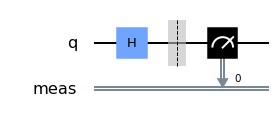

In [9]:
qiskit_circuit = qiskit.QuantumCircuit(1)
qiskit_circuit.h(0)
qiskit_circuit.measure_all()

qiskit_circuit.draw(output='mpl')

In [10]:
tket_circuit = qiskit_to_tk(qiskit_circuit)
tket_circuit

[H q[0]; Barrier q[0]; Measure q[0] --> meas[0]; ]

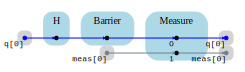

In [11]:
Graph(tket_circuit).get_DAG()

In [12]:
my_tket_fake_backend.compile_circuit(tket_circuit)

In [13]:
tket_circuit

[U3(0.5*PI, 0*PI, 1*PI) FCNode[0]; Barrier FCNode[0]; Measure FCNode[0] --> meas[0]; ]

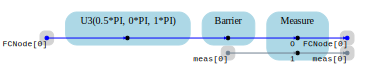

In [14]:
Graph(tket_circuit).get_DAG()